In [1]:
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader
from torchsampler import ImbalancedDatasetSampler
from yaml import load as load_yaml, FullLoader

from dataset import KIDataset, train_test_split_stratified
from models.inceptiontime import LitInceptionTimeModel
from processor.processor import Leif
from utils.const import SEED
from utils.data import binarize
from utils.metric import patient_soft_accuracy
from utils.misc import set_random_state
from utils.path import config_path, checkpoint_path

set_random_state(SEED)
!conda activate eyetrackpdc

# Data parameters
BINARY_CLF = True

### Load Configs

In [2]:
with open(config_path.joinpath('leif.yaml')) as reader:
    processor_config = load_yaml(reader, Loader=FullLoader)
with open(config_path.joinpath('transformer.yaml')) as reader:
    transformer_config = load_yaml(reader, Loader=FullLoader)

### Initialize the processor

In [3]:
# Configure processor
processor = Leif(processor_config)

### Prepare Data (segments)

In [4]:
# Initialize Datasets
train_val_ds = KIDataset(data_processor=processor, train=True, bundle_as_trials=False, use_triplets=False)
train_ds, val_ds = train_test_split_stratified(train_val_ds, test_size=0.2)
test_ds = KIDataset(data_processor=processor, train=False, bundle_as_trials=False, use_triplets=False)

# Binarize dataset after split to make sure split is stratified w.r.t all three classes
if BINARY_CLF:
    for ds in [train_ds, val_ds, test_ds]:
        binarize(ds)

# Initialize Dataloaders
train_dl = DataLoader(train_ds,
                      batch_size=len(train_ds),
                      sampler=ImbalancedDatasetSampler(train_ds, callback_get_label=lambda item: item.y))
val_dl = DataLoader(val_ds, batch_size=(len(val_ds)))
test_dl = DataLoader(test_ds, batch_size=(len(test_ds)))

loaded dataset from C:\Users\hejpa\Documents\GitHub\eye-track-pdc\data\ki\tmp\ki-HC,PD_OFF,PD_ON-seg-train.pth
loaded dataset from C:\Users\hejpa\Documents\GitHub\eye-track-pdc\data\ki\tmp\ki-HC,PD_OFF,PD_ON-seg-test.pth


### Initialize and Load Models

In [5]:
inception_time = LitInceptionTimeModel.load_from_checkpoint(checkpoint_path.joinpath('epoch=51-step=208.ckpt'))

# Freeze parameters of the encoder
inception_time.freeze()

# Initialize classifiers
forest_clf = RandomForestClassifier(
    random_state=SEED,
    n_jobs=1,
    n_estimators=200,
    max_samples=0.826,
    max_depth=2
)
ridge_clf = RidgeClassifier(alpha=1e2, random_state=SEED)

### Fit Classifiers

In [6]:
# For evaluation metrics
# TODO move to dataset as class_names attribute
labels = ['HC', 'PD']

# Batch is entire dataset
train_batch = next(iter(train_dl))
test_batch = next(iter(test_dl))

In [7]:
train_embeddings = inception_time(train_batch.x)
forest_clf.fit(train_embeddings.detach(), train_batch.y)
ridge_clf.fit(train_embeddings.detach(), train_batch.y)

C:\Users\hejpa\Anaconda3\envs\eyetrackpdc\lib\site-packages\torch\nn\modules\conv.py:310: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Convolution.cpp:896.)
  self.padding, self.dilation, self.groups)


RidgeClassifier(alpha=100.0, random_state=42)

### Evaluate random forest classifier

mean F1 score: 0.5563766284693478
Segment classification on test set:
              precision    recall  f1-score   support

          HC       0.38      0.61      0.47       297
          PD       0.77      0.56      0.65       682

    accuracy                           0.58       979
   macro avg       0.57      0.58      0.56       979
weighted avg       0.65      0.58      0.59       979



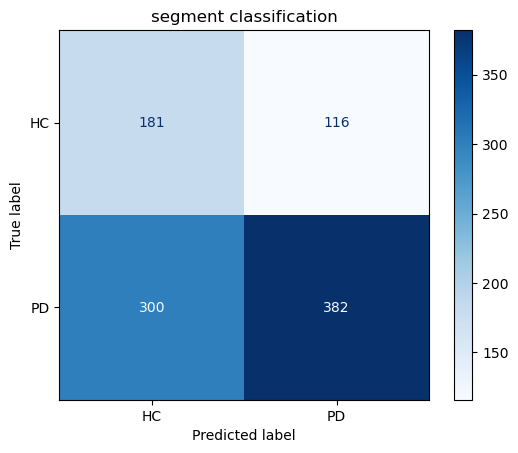

In [8]:
test_embeddings = inception_time(test_batch.x)

pred = forest_clf.predict(test_embeddings.detach())

# The RidgeClassifier maps the targets to {-1, 1}, but our labels are {0, 1}
pred[pred < 0] = 0

# Compute metrics
report = classification_report(test_batch.y, pred, target_names=labels)

print(f"mean F1 score: {f1_score(test_batch.y, pred, average='macro')}")
print(f'Segment classification on test set:\n{report}')

# Construct the confusion matrix
cf_matrix = confusion_matrix(test_batch.y, pred)

figure = ConfusionMatrixDisplay(cf_matrix, display_labels=labels).plot(cmap='Blues')
figure.ax_.set_title('segment classification')
plt.show()

mean F1 score: 0.5608242686983891
Segment classification on test set:
              precision    recall  f1-score   support

          HC       0.38      0.43      0.40       297
          PD       0.74      0.70      0.72       682

    accuracy                           0.62       979
   macro avg       0.56      0.56      0.56       979
weighted avg       0.63      0.62      0.62       979



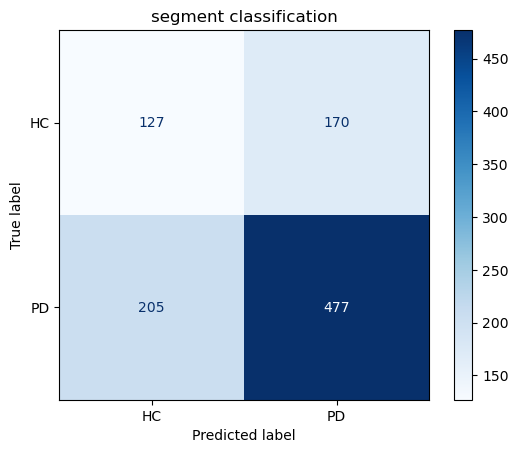

In [9]:
pred = ridge_clf.predict(test_embeddings.detach())

# The RidgeClassifier maps the targets to {-1, 1}, but our labels are {0, 1}
pred[pred < 0] = 0

# Compute metrics
report = classification_report(test_batch.y, pred, target_names=labels)

print(f"mean F1 score: {f1_score(test_batch.y, pred, average='macro')}")
print(f'Segment classification on test set:\n{report}')

# Construct the confusion matrix
cf_matrix = confusion_matrix(test_batch.y, pred)

figure = ConfusionMatrixDisplay(cf_matrix, display_labels=labels).plot(cmap='Blues')
figure.ax_.set_title('segment classification')
plt.show()

aggregated f1 score: 0.6812144212523719
aggregated accuracy: 70.83%


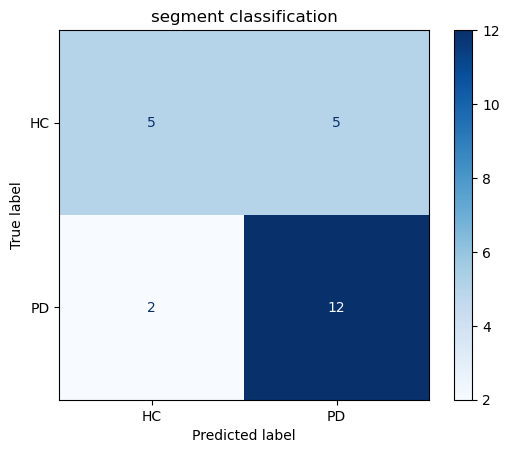

In [13]:
p_pred, p_label, p_acc = patient_soft_accuracy(segment_scores=pred, y=test_batch.y, z=test_batch.z,
                                               threshold=.5)
print(f"aggregated f1 score: {f1_score(p_label, p_pred, average='macro')}")
print(f'aggregated accuracy: {p_acc:.2%}')

cf_matrix = confusion_matrix(p_label, p_pred)

figure = ConfusionMatrixDisplay(cf_matrix, display_labels=labels).plot(cmap='Blues')
figure.ax_.set_title('segment classification')
plt.show()